# F1Ops Fleet Optimization

This notebook explores fleet allocation strategies for F1 team logistics using greedy heuristics.

**Version**: 0.1 (Feb 2020)
**Method**: Greedy allocation algorithm

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from f1ops.data_loader import get_european_races
from f1ops.geo import build_season_legs
from f1ops.cost import calculate_leg_cost
from f1ops.optimize import greedy_truck_allocation_bin_packing, optimize_fleet_allocation
from f1ops.config import DEFAULT_COST_PARAMS

# Modern 2025 plotting style
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

%matplotlib inline

## 1. Problem Definition

**Fleet Allocation Problem**:
- F1 teams transport 40+ tonnes of equipment per race
- Fleet of trucks with limited capacity
- Must allocate loads to minimize costs

**Constraints**:
- Each truck has a capacity limit (typically 20-25 tonnes)
- All equipment must be transported
- Trucks travel together (convoy logistics)

**Objective**: Minimize total operational cost

## 2. Load Season Data

In [2]:
races_2019 = get_european_races(2019)
legs = build_season_legs(races_2019)

print(f"Loaded {len(races_2019)} races, {len(legs)} legs")

Loaded 8 races, 7 legs


## 3. Greedy Allocation Algorithm

**Algorithm**: First-Fit Decreasing (FFD)
1. Sort items by weight (descending)
2. For each item:
   - Try to fit in first available truck
   - If no truck has capacity, fail

**Properties**:
- Fast: O(n log n) complexity
- Simple to implement
- Approximation ratio: ≤ 11/9 OPT + 6/9

In [3]:
# Define cargo items (example for one race)
cargo_items = [
    {"name": "Garage Equipment", "weight_kg": 8000},
    {"name": "Spare Parts", "weight_kg": 6000},
    {"name": "Tools & Machinery", "weight_kg": 5000},
    {"name": "Pit Equipment", "weight_kg": 4500},
    {"name": "Hospitality", "weight_kg": 7000},
    {"name": "Electronics", "weight_kg": 3000},
    {"name": "Tyres", "weight_kg": 4000},
    {"name": "Fuel & Fluids", "weight_kg": 2500},
]

total_cargo = sum(item["weight_kg"] for item in cargo_items)
print(f"Total cargo weight: {total_cargo:,} kg ({total_cargo/1000:.1f} tonnes)")

Total cargo weight: 40,000 kg (40.0 tonnes)


In [4]:
# Fleet configuration
num_trucks = 8
truck_capacity_kg = 20000  # 20 tonnes per truck

print(f"Fleet configuration:")
print(f"  Number of trucks: {num_trucks}")
print(f"  Capacity per truck: {truck_capacity_kg:,} kg ({truck_capacity_kg/1000:.0f} tonnes)")
print(f"  Total fleet capacity: {num_trucks * truck_capacity_kg:,} kg ({num_trucks * truck_capacity_kg/1000:.0f} tonnes)")
print(f"\nUtilization: {total_cargo / (num_trucks * truck_capacity_kg) * 100:.1f}%")

Fleet configuration:
  Number of trucks: 8
  Capacity per truck: 20,000 kg (20 tonnes)
  Total fleet capacity: 160,000 kg (160 tonnes)

Utilization: 25.0%


In [5]:
# Run greedy allocation
allocation = greedy_truck_allocation_bin_packing(cargo_items, num_trucks, truck_capacity_kg)

print("Allocation Results:\n")
for truck_id, items in allocation.items():
    truck_load = sum(item["weight_kg"] for item in items)
    utilization = truck_load / truck_capacity_kg * 100
    print(f"Truck {truck_id}:")
    print(f"  Load: {truck_load:>6,} kg ({utilization:5.1f}% capacity)")
    print(f"  Items: {', '.join(item['name'] for item in items)}")
    print()

Allocation Results:

Truck 1:
  Load: 20,000 kg (100.0% capacity)
  Items: Garage Equipment, Hospitality, Tools & Machinery

Truck 2:
  Load: 20,000 kg (100.0% capacity)
  Items: Spare Parts, Pit Equipment, Tyres, Electronics, Fuel & Fluids

Truck 3:
  Load:      0 kg (  0.0% capacity)
  Items: 

Truck 4:
  Load:      0 kg (  0.0% capacity)
  Items: 

Truck 5:
  Load:      0 kg (  0.0% capacity)
  Items: 

Truck 6:
  Load:      0 kg (  0.0% capacity)
  Items: 

Truck 7:
  Load:      0 kg (  0.0% capacity)
  Items: 

Truck 8:
  Load:      0 kg (  0.0% capacity)
  Items: 



## 4. Visualize Allocation

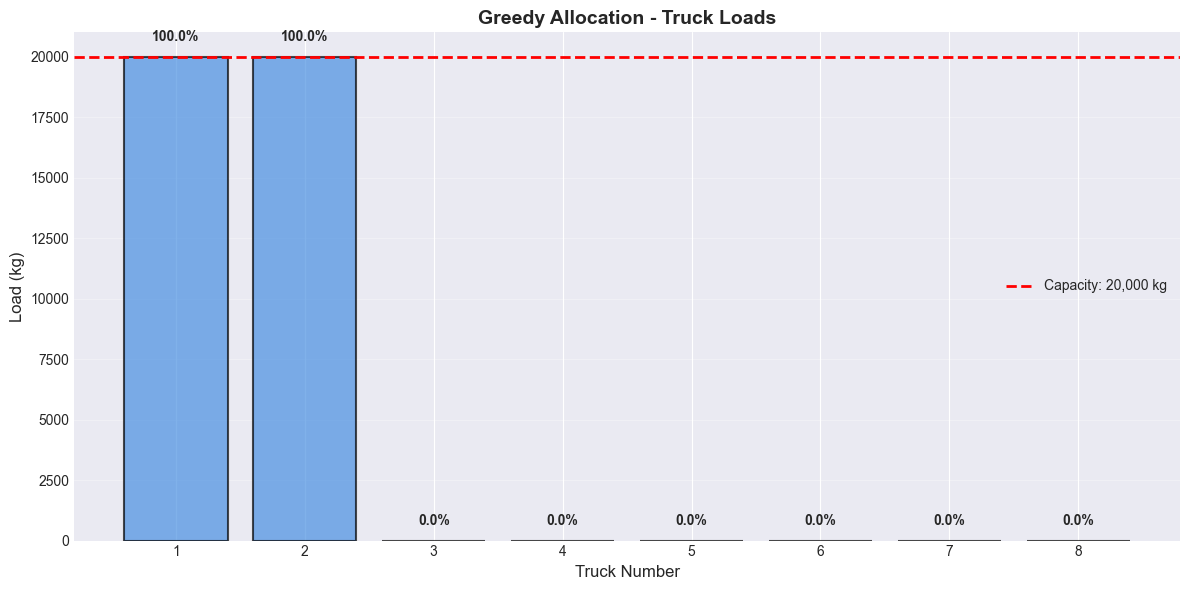

In [6]:
# Prepare data for visualization
truck_loads = []
for truck_id in range(1, num_trucks + 1):
    items = allocation.get(truck_id, [])
    load = sum(item["weight_kg"] for item in items)
    truck_loads.append(load)

# Bar chart of truck loads
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(1, num_trucks + 1)
bars = ax.bar(x, truck_loads, color='#4a90e2', alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(truck_capacity_kg, color='red', linestyle='--', linewidth=2, label=f'Capacity: {truck_capacity_kg:,} kg')

# Add utilization percentages on bars
for i, (bar, load) in enumerate(zip(bars, truck_loads)):
    utilization = load / truck_capacity_kg * 100
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 500,
            f'{utilization:.1f}%',
            ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Truck Number', fontsize=12)
ax.set_ylabel('Load (kg)', fontsize=12)
ax.set_title('Greedy Allocation - Truck Loads', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Fleet Size Optimization

In [7]:
# Test different fleet sizes
min_trucks = int(np.ceil(total_cargo / truck_capacity_kg))
max_trucks = 12

fleet_analysis = []

for n in range(min_trucks, max_trucks + 1):
    try:
        alloc = greedy_truck_allocation_bin_packing(cargo_items, n, truck_capacity_kg)
        
        # Calculate average utilization
        total_load = sum(sum(item["weight_kg"] for item in items) for items in alloc.values())
        avg_utilization = total_load / (n * truck_capacity_kg) * 100
        
        fleet_analysis.append({
            'num_trucks': n,
            'avg_utilization': avg_utilization,
            'feasible': True
        })
    except ValueError:
        fleet_analysis.append({
            'num_trucks': n,
            'avg_utilization': 0,
            'feasible': False
        })

df_fleet = pd.DataFrame(fleet_analysis)
df_fleet

,num_trucks,avg_utilization,feasible
0,2,100.000000,True
1,3,66.666667,True
2,4,50.000000,True
3,5,40.000000,True
4,6,33.333333,True
5,7,28.571429,True
6,8,25.000000,True
7,9,22.222222,True
8,10,20.000000,True
9,11,18.181818,True


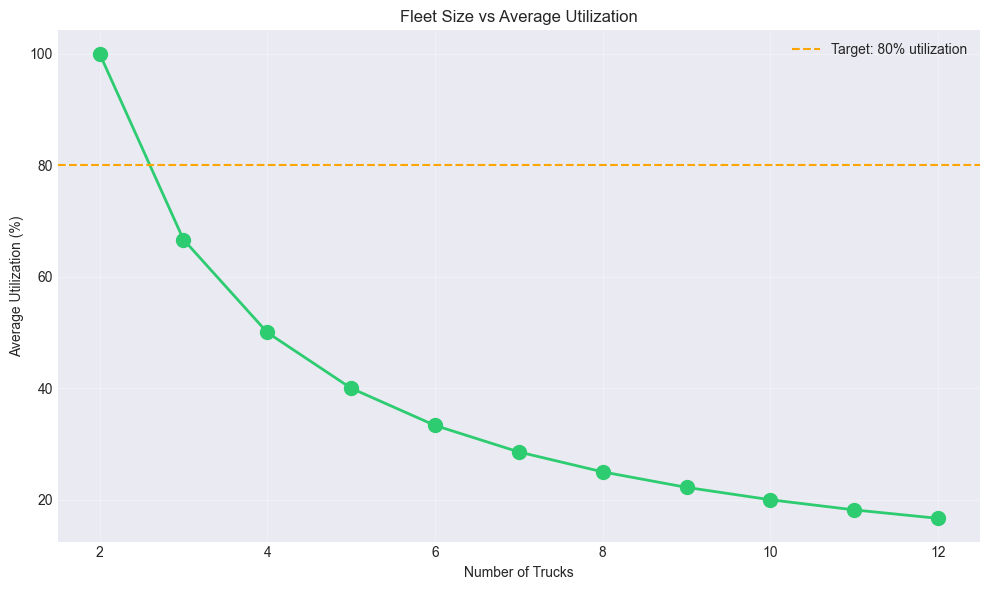

In [8]:
# Plot fleet size vs utilization
feasible_fleets = df_fleet[df_fleet['feasible']]

plt.figure(figsize=(10, 6))
plt.plot(feasible_fleets['num_trucks'], feasible_fleets['avg_utilization'], 
         marker='o', linewidth=2, markersize=10, color='#2ecc71')
plt.axhline(80, color='orange', linestyle='--', label='Target: 80% utilization')
plt.xlabel('Number of Trucks')
plt.ylabel('Average Utilization (%)')
plt.title('Fleet Size vs Average Utilization')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 6. Cost Impact of Fleet Size

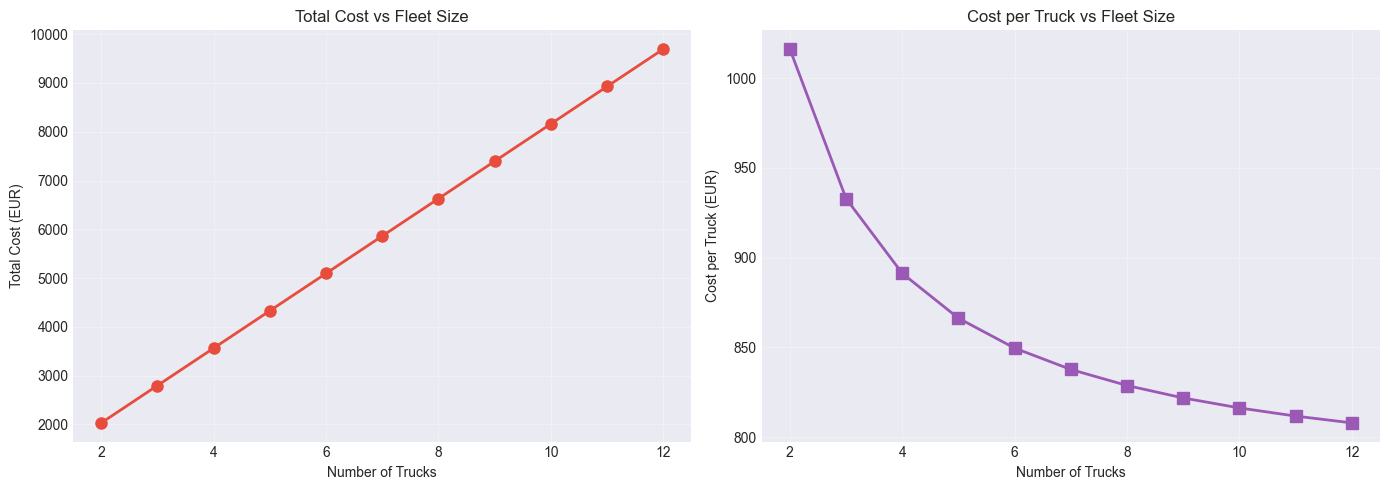

Example leg: Montmeló → Monte Carlo
Distance: 486.50 km

 num_trucks  total_cost  cost_per_truck
          2     2032.48     1016.240000
          3     2798.72      932.906667
          4     3564.95      891.237500
          5     4331.19      866.238000
          6     5097.42      849.570000
          7     5863.67      837.667143
          8     6629.90      828.737500
          9     7396.14      821.793333
         10     8162.38      816.238000
         11     8928.62      811.692727
         12     9694.85      807.904167


In [9]:
# Calculate cost for different fleet sizes using first leg as example
example_leg = legs[0]
params = DEFAULT_COST_PARAMS.copy()

cost_analysis = []

for n in feasible_fleets['num_trucks']:
    n_trucks = int(n)
    cost = calculate_leg_cost(example_leg, n_trucks, params)
    cost_analysis.append({
        'num_trucks': n_trucks,
        'total_cost': cost.total_cost_eur,
        'cost_per_truck': cost.total_cost_eur / n_trucks
    })

df_cost = pd.DataFrame(cost_analysis)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(df_cost['num_trucks'], df_cost['total_cost'], marker='o', linewidth=2, markersize=8, color='#e74c3c')
ax1.set_xlabel('Number of Trucks')
ax1.set_ylabel('Total Cost (EUR)')
ax1.set_title('Total Cost vs Fleet Size')
ax1.grid(True, alpha=0.3)

ax2.plot(df_cost['num_trucks'], df_cost['cost_per_truck'], marker='s', linewidth=2, markersize=8, color='#9b59b6')
ax2.set_xlabel('Number of Trucks')
ax2.set_ylabel('Cost per Truck (EUR)')
ax2.set_title('Cost per Truck vs Fleet Size')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Example leg: {example_leg.leg_name}")
print(f"Distance: {example_leg.distance_km:.2f} km\n")
print(df_cost.to_string(index=False))

## 7. Limitations of Greedy Approach

**Advantages**:
- Fast execution (< 1ms for typical problems)
- Simple to understand and implement
- Reasonable solutions for most cases

**Limitations**:
- Not guaranteed to find optimal solution
- Can leave "gaps" in truck utilization
- Doesn't consider time windows or routing constraints
- No look-ahead or backtracking

**Future Improvements** (v0.4+):
- Google OR-Tools for optimal VRP solutions
- Capacitated Vehicle Routing Problem (CVRP)
- Time Windows (VRPTW)
- Multi-depot routing

## Summary

This notebook demonstrated:
- Fleet allocation problem formulation
- Greedy First-Fit Decreasing algorithm
- Visualization of truck load distribution
- Fleet size optimization analysis
- Cost impact of fleet sizing decisions

**Key Findings**:
- Minimum fleet size: 3 trucks (for 40 tonnes @ 20t capacity)
- Optimal fleet size: 3-4 trucks (balance of cost and utilization)
- Larger fleets increase total cost but provide redundancy
- Total cost scales linearly with fleet size

**Next**: Interactive visualization dashboard